## Initial data engineering

#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight

### Reading the spreadseets

In [4]:
nome_planilha = 'AlunosUTFPRBaseDadosTratada.xlsx'
relacao_alunos = pd.read_excel(nome_planilha, sheet_name='Relacao_Alunos')
historico = pd.read_excel(nome_planilha, sheet_name='Historico')

In [6]:
relacao_alunos.sort_values(by='id').head(5)

,#,id,Ano Ingresso,Per. Ingresso,Curso,Forma de Ingresso,Tipo de Cota,Sigla Cota,Escola Pública?,Coeficiente,...,Sexo,Idade,Data Nascimento,Cidade,Estado,Grupo (Étnico),Situação Atual do Aluno,Período do Aluno,Ano Desistência,Período Desistências
616,1298,+1hm9t,2010,1,Curso Superior De Tecnologia Em Análise E Dese...,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.5357,...,M,30,26/10/1988,Ponta Grossa,PR,Branca,Jubilado,6,2016.0,1.0
1137,308,+1oahc,2013,2,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Categoria 2 - cotista oriundo de família com r...,Categoria 2,Escola Pública,0.0000,...,M,27,13/07/1992,Ponta Grossa,PR,Não declarado,Desistente,1,2013.0,2.0
134,502,+4biin,2015,2,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Ampla concorrência,Não cotista,Escola Particular,0.7976,...,M,22,24/11/1996,Ponta Grossa,PR,Branca,Regular,8,NaN,NaN
325,861,+4ismk,2019,2,Ciência Da Computação,Transferência,Sem política de cotas,Sem cotas,-,0.7647,...,M,19,01/08/2000,Ponta Grossa,PR,Branca,Regular,2,NaN,NaN
892,1354,+4jfnz,2011,1,Curso Superior De Tecnologia Em Análise E Dese...,SISU - Sistema de Seleção Unificada,Ampla concorrência,Não cotista,Escola Pública,0.8245,...,M,48,01/09/1971,Ponta Grossa,PR,Branca,Formado,6,2015.0,2.0


In [7]:
historico.head()

,#,id,Cod. Disciplina,Nome Disciplina,Per. Aluno,Ano Lanç.,Per. Lanç.,Nota,Freq.(%),Situação Disc.,Média da Turma,Qtde Alunos Turma
0,1,a+ntz8,SI31C,ALGORITMOS,1,2007,1,0.0,41.0,Reprovado por Nota/Frequência,3.7,46
1,2,a+ntz8,SI31F,COMUNICAÇÃO LINGUÍSTICA,1,2007,1,7.1,97.4,Aprovado por Nota/Frequência,5.2,40
2,3,a+ntz8,SI31G,EMPREENDEDORISMO,1,2007,1,9.0,94.7,Aprovado por Nota/Frequência,6.0,46
3,4,a+ntz8,SI31E,ÁLGEBRA,1,2007,1,0.6,67.8,Reprovado por Nota/Frequência,4.9,47
4,5,a+ntz8,SI31A,FUNDAMENTOS DA COMPUTAÇÃO,1,2007,1,4.7,84.6,Reprovado por Nota,5.8,40


### Creating a Pandas dataframe

In [8]:
relacao_alunos.columns = relacao_alunos.columns.str.strip()
historico.columns = historico.columns.str.strip()

disciplinas_criticas = ['ALGORITMOS E ESTRUTURA DE DADOS 1', 'ALGORITMOS E ESTRUTURA DE DADOS 2',
                        'ALGORITMOS', 'ESTRUTURA DE DADOS', 'LINGUAGEM DE PROGRAMAÇÃO ESTRUTURADA',
                        'ESTRUTURA DE DADOS 1', 'ESTRUTURA DE DADOS 2', 'LABORATÓRIO DE ESTRUTURA DE DADOS'
                                                                        'CÁLCULO DIFERENCIAL E INTEGRAL 1', 'CÁLCULO',
                        'LÓGICA MATEMÁTICA', 'MATEMÁTICA DISCRETA']

historico['disciplina_critica'] = historico['Nome Disciplina'].apply(
    lambda x: 1 if x in disciplinas_criticas else 0).astype(int)
historico['desvio_nota_turma'] = historico['Nota'] - historico['Média da Turma']
historico['nota_abaixo_media_turma'] = historico['desvio_nota_turma'].apply(lambda x: 1 if x < 0 else 0).astype(int)
historico['reprovado'] = historico['Situação Disc.'].str.contains('Reprovado').astype(int)

agregado_geral = historico.groupby('id').agg(
    media_notas=('Nota', 'mean'),
    num_disciplinas_cursadas=('id', 'count'),
    num_reprovacoes=('reprovado', 'sum'),
    media_frequencia=('Freq.(%)', 'mean'),
    media_desvio_nota_turma=('desvio_nota_turma', 'mean'),
    notas_abaixo_media_turma=('nota_abaixo_media_turma', 'sum'),
).reset_index()

reprovacoes_criticas = historico[
    (historico['reprovado'] == 1) & (historico['disciplina_critica'] == 1)
    ]

reprovacoes_criticas_count = reprovacoes_criticas.groupby('id').size().reset_index(
    name='reprovacoes_em_disciplinas_criticas')
agregado_geral = agregado_geral.merge(reprovacoes_criticas_count, on='id', how='left')
agregado_geral['reprovacoes_em_disciplinas_criticas'] = agregado_geral['reprovacoes_em_disciplinas_criticas'].fillna(
    0).astype(int)

agregado_geral['porcentagem_reprovacoes'] = agregado_geral['num_reprovacoes'] / agregado_geral[
    'num_disciplinas_cursadas']

historico_sem1 = historico[historico['Per. Aluno'] == 1].copy()
agregado_sem1 = historico_sem1.groupby('id').agg(
    media_notas_sem1=('Nota', 'mean'),
    num_reprovacoes_sem1=('reprovado', 'sum'),
    media_frequencia_sem1=('Freq.(%)', 'mean')
).reset_index()

dados_alunos = pd.merge(relacao_alunos, agregado_geral, on='id', how='left')
dados_alunos = pd.merge(dados_alunos, agregado_sem1, on='id', how='left')
dados = pd.merge(dados_alunos, historico, on='id', how='left')

dados_alunos['Situação Atual do Aluno'] = dados_alunos['Situação Atual do Aluno'].apply(
    lambda x: 1 if x == 'Desistente' else 0)

for column in dados_alunos.select_dtypes(include=['object']).columns:
    dados_alunos[column] = dados_alunos[column].fillna(dados_alunos[column].mode()[0])

for col in dados_alunos:
    dados_alunos[col] = dados_alunos[col].fillna(0)

colunas_numericas = dados.select_dtypes(include=['number']).columns
dados[colunas_numericas] = dados[colunas_numericas].fillna(dados[colunas_numericas].median())

colunas_nao_numericas = dados.select_dtypes(exclude=['number']).columns
for coluna in colunas_nao_numericas:
    moda = dados[coluna].mode()[0]
    dados[coluna] = dados[coluna].fillna(moda)

scaler = MinMaxScaler()
dados_alunos[['Nota Enem',
              'Idade',
              'num_reprovacoes',
              'media_notas',
              'media_frequencia',
              'media_desvio_nota_turma',
              'media_notas_sem1',
              'num_reprovacoes_sem1',
              'media_frequencia_sem1',
              'reprovacoes_em_disciplinas_criticas',
              'num_disciplinas_cursadas']
] = scaler.fit_transform(dados_alunos[['Nota Enem',
                                       'Idade',
                                       'num_reprovacoes',
                                       'media_notas',
                                       'media_frequencia',
                                       'media_desvio_nota_turma',
                                       'media_notas_sem1',
                                       'num_reprovacoes_sem1',
                                       'media_frequencia_sem1',
                                       'reprovacoes_em_disciplinas_criticas',
                                       'num_disciplinas_cursadas'
                                       ]])

print(dados_alunos['Situação Atual do Aluno'].value_counts())

Situação Atual do Aluno
0    958
1    930
Name: count, dtype: int64


In [9]:
features = [
    'Coeficiente', 'Idade', 'Nota Enem', 'media_notas', 'num_disciplinas_cursadas',
    'media_frequencia', 'porcentagem_reprovacoes', 'num_reprovacoes', 'media_desvio_nota_turma',
    'media_notas_sem1', 'num_reprovacoes_sem1', 'media_frequencia_sem1', 'Situação Atual do Aluno',
    'reprovacoes_em_disciplinas_criticas'
]
dados_alunos = dados_alunos[features]
dados_alunos.head()

,Coeficiente,Idade,Nota Enem,media_notas,num_disciplinas_cursadas,media_frequencia,porcentagem_reprovacoes,num_reprovacoes,media_desvio_nota_turma,media_notas_sem1,num_reprovacoes_sem1,media_frequencia_sem1,Situação Atual do Aluno,reprovacoes_em_disciplinas_criticas
0,0.46520,0.260870,0.803324,0.518419,0.145833,0.893238,0.571429,0.169014,0.503225,0.557627,0.038462,0.967500,0,0.125
1,0.49400,0.217391,0.760136,0.503363,0.506944,0.764699,0.397260,0.408451,0.527046,0.583729,0.269231,0.864029,0,0.250
2,0.64060,0.260870,0.841098,0.695254,0.090278,0.889615,0.153846,0.028169,0.747324,0.638983,0.038462,0.926833,0,0.000
3,0.81947,0.217391,0.825107,0.844972,0.131944,0.977421,0.000000,0.000000,0.847799,0.825424,0.000000,0.982833,0,0.000
4,0.21370,0.500000,0.755981,0.233191,0.041667,0.605333,0.833333,0.070423,0.385576,0.232203,0.096154,0.605333,0,0.125


### Clusterization

/tmp/ipykernel_73448/1552443145.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_alunos['cluster'] = clusters
/tmp/ipykernel_73448/1552443145.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_alunos[['cluster']] = scaler.fit_transform(dados_alunos[['cluster']])


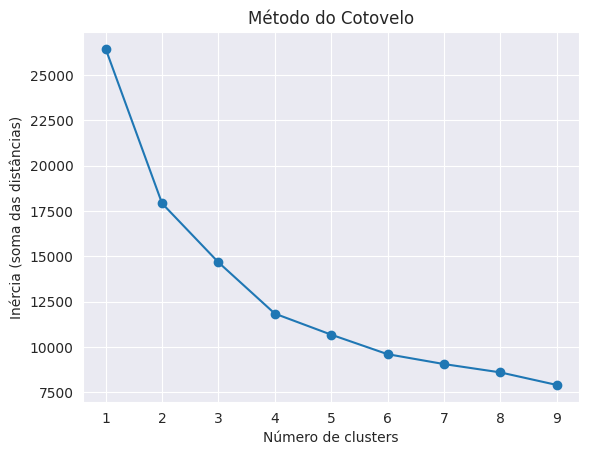

In [113]:
X = dados_alunos.drop(columns=['Situação Atual do Aluno'])
y = dados_alunos['Situação Atual do Aluno']

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

scaler = MinMaxScaler()
dados_alunos['cluster'] = clusters
dados_alunos[['cluster']] = scaler.fit_transform(dados_alunos[['cluster']])

inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia (soma das distâncias)')
plt.title('Método do Cotovelo')
plt.show()

In [96]:
dados_alunos.head()

,Coeficiente,Idade,Nota Enem,media_notas,num_disciplinas_cursadas,media_frequencia,porcentagem_reprovacoes,num_reprovacoes,media_desvio_nota_turma,media_notas_sem1,num_reprovacoes_sem1,media_frequencia_sem1,Situação Atual do Aluno,reprovacoes_em_disciplinas_criticas,cluster
0,0.46520,0.260870,0.803324,0.518419,0.145833,0.893238,0.571429,0.169014,0.503225,0.557627,0.038462,0.967500,0,0.125,0.0
1,0.49400,0.217391,0.760136,0.503363,0.506944,0.764699,0.397260,0.408451,0.527046,0.583729,0.269231,0.864029,0,0.250,0.0
2,0.64060,0.260870,0.841098,0.695254,0.090278,0.889615,0.153846,0.028169,0.747324,0.638983,0.038462,0.926833,0,0.000,0.5
3,0.81947,0.217391,0.825107,0.844972,0.131944,0.977421,0.000000,0.000000,0.847799,0.825424,0.000000,0.982833,0,0.000,0.5
4,0.21370,0.500000,0.755981,0.233191,0.041667,0.605333,0.833333,0.070423,0.385576,0.232203,0.096154,0.605333,0,0.125,1.0


### Splitting train and test

In [10]:
X = dados_alunos.drop(columns=['Situação Atual do Aluno'])
y = dados_alunos['Situação Atual do Aluno']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Function for testing the models

In [117]:
def fit_and_predict(model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Não Evasor', 'Evasor'],
                yticklabels=['Não Evasor', 'Evasor'])
    plt.title('Matriz de Confusão')
    plt.show()

    return y_pred

## Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       191
           1       0.84      0.80      0.82       187

    accuracy                           0.82       378
   macro avg       0.82      0.82      0.82       378
weighted avg       0.82      0.82      0.82       378



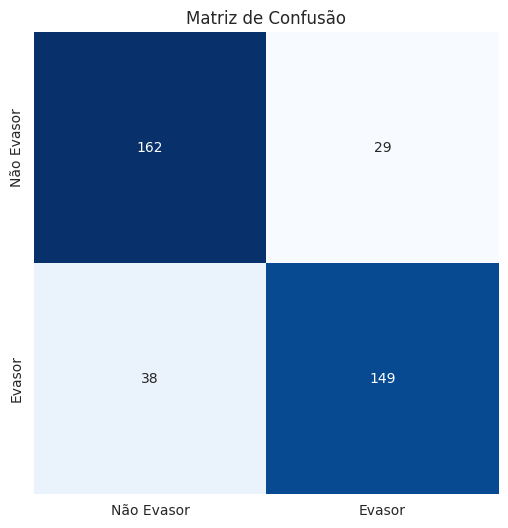

In [118]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
y_pred_lr = fit_and_predict(lr_model)

In [120]:
print("\nAcurácia:", accuracy_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))


Acurácia: 0.8227513227513228
F1-Score: 0.8164383561643835


## Decision Tree

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       191
           1       0.81      0.83      0.82       187

    accuracy                           0.82       378
   macro avg       0.82      0.82      0.82       378
weighted avg       0.82      0.82      0.82       378



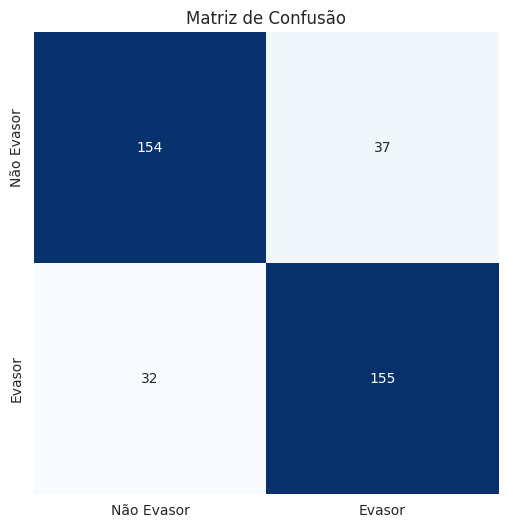

In [121]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)
y_pred_dt = fit_and_predict(dt_model)

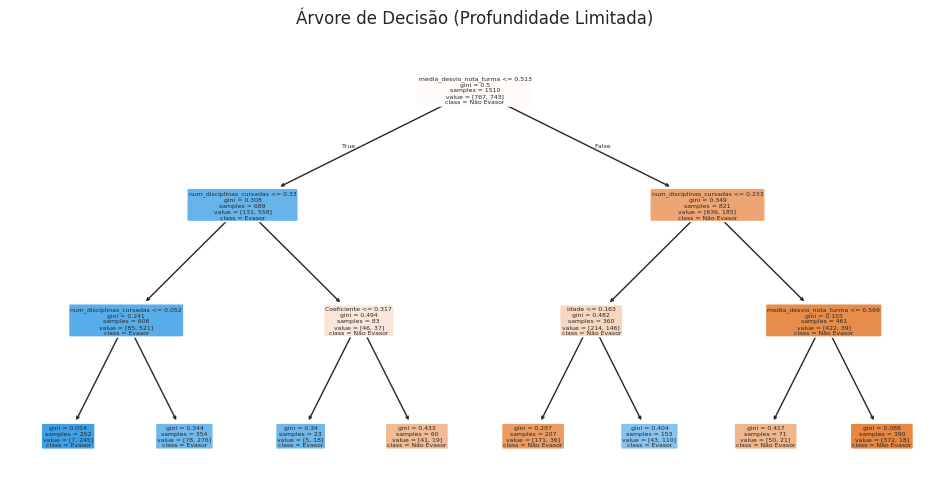

In [122]:
plt.figure(figsize=(12, 6))
plot_tree(dt_model, feature_names=X.columns, class_names=['Não Evasor', 'Evasor'], filled=True, rounded=True)
plt.title('Árvore de Decisão (Profundidade Limitada)')
plt.show()

## Random Forest

Random Forest: 0.8344 ± 0.0117
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       191
           1       0.87      0.82      0.84       187

    accuracy                           0.85       378
   macro avg       0.85      0.85      0.85       378
weighted avg       0.85      0.85      0.85       378



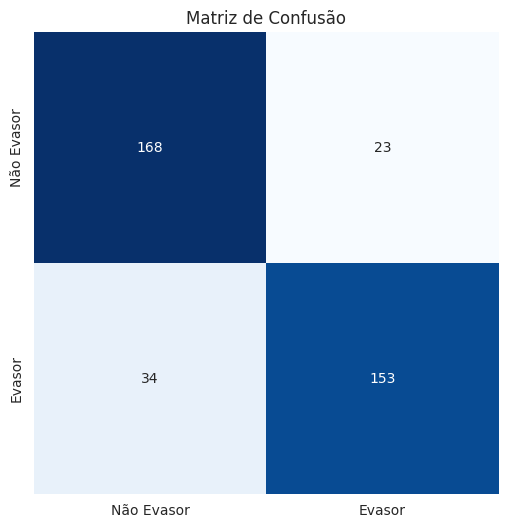

In [123]:
weights = class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

balanced_rf = RandomForestClassifier(class_weight=class_weights, n_estimators=100)
balanced_rf_scores = cross_val_score(balanced_rf, X_train, y_train, cv=5)
print(f"Random Forest: {balanced_rf_scores.mean():.4f} ± {balanced_rf_scores.std():.4f}")

y_pred_rf = fit_and_predict(balanced_rf)

In [124]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(balanced_rf, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

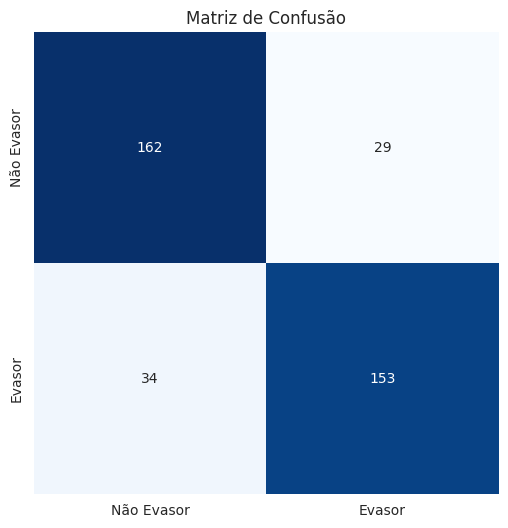

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       191
           1       0.84      0.82      0.83       187

    accuracy                           0.83       378
   macro avg       0.83      0.83      0.83       378
weighted avg       0.83      0.83      0.83       378


Acurácia: 0.8333333333333334
F1-Score: 0.8292682926829268


In [125]:
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', balanced_rf),
        ('decision_tree', dt_model),
        ('logistic_regression', lr_model)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_pred_clf = voting_clf.predict(X_test)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_clf), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Evasor', 'Evasor'],
            yticklabels=['Não Evasor', 'Evasor'])
plt.title('Matriz de Confusão')
plt.show()
print(classification_report(y_test, y_pred_clf))

print("\nAcurácia:", accuracy_score(y_test, y_pred_clf))
print("F1-Score:", f1_score(y_test, y_pred_clf))

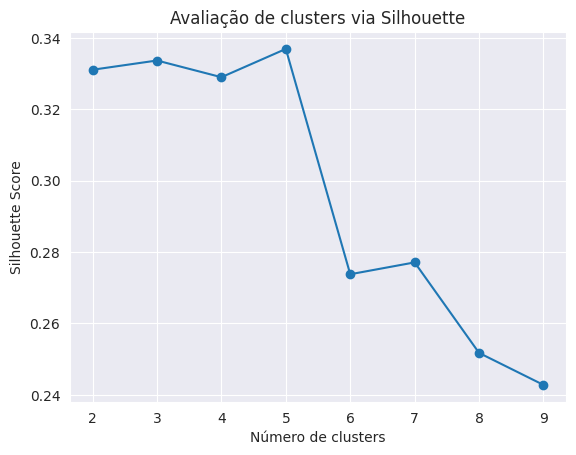

In [51]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):  # começa do 2 porque silhouette não é definido para k=1
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(range(2, 10), scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Avaliação de clusters via Silhouette')
plt.show()

## Neural Networks

In [3]:
dados_preparados_csv = 'dados_preparados.csv'
dados_preparados_df = pd.read_csv(dados_preparados_csv)
dados_preparados_df.head()

,#_x,id,Ano Ingresso,Per. Ingresso,Curso,Forma de Ingresso,Tipo de Cota,Sigla Cota,Escola Pública?,Coeficiente,...,Cod. Disciplina,Nome Disciplina,Per. Aluno,Ano Lanç.,Per. Lanç.,Nota,Freq.(%),Situação Disc.,Média da Turma,Qtde Alunos Turma
0,1,+bwsow,2010,1,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.0222,...,CC31C,INTRODUÇÃO À CIÊNCIA DA COMPUTAÇÃO,1.0,2010.0,1.0,0.0,23.5,Reprovado por Nota/Frequência,6.0,46.0
1,1,+bwsow,2010,1,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.0222,...,CC31B,LÓGICA MATEMÁTICA,1.0,2010.0,1.0,0.0,71.1,Reprovado por Nota/Frequência,5.4,46.0
2,1,+bwsow,2010,1,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.0222,...,CC31A,ALGORITMOS,1.0,2010.0,1.0,0.0,35.4,Reprovado por Nota/Frequência,5.7,45.0
3,1,+bwsow,2010,1,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.0222,...,CC31G,GEOMETRIA ANALÍTICA E ÁLGEBRA LINEAR,1.0,2010.0,1.0,1.0,16.2,Reprovado por Nota/Frequência,2.6,46.0
4,1,+bwsow,2010,1,Ciência Da Computação,SISU - Sistema de Seleção Unificada,Cotista,Cotista,Escola Pública,0.0222,...,CC31D,CÁLCULO DIFERENCIAL E INTEGRAL 1,1.0,2010.0,1.0,0.0,47.6,Reprovado por Nota/Frequência,3.2,46.0


In [4]:
dados_preparados_df = dados_preparados_df[
    ['Nota', 'Média da Turma', 'Qtde Alunos Turma', 'Situação Atual do Aluno', 'Período do Aluno', 'Sigla Cota']]
dados_preparados_df = dados_preparados_df.dropna()
dados_preparados_df = dados_preparados_df.sample(frac=1, random_state=42).reset_index(drop=True)
dados_preparados_df['Sigla Cota'] = dados_preparados_df['Sigla Cota'].apply(
    lambda valor: 0 if valor == 'Não cotista' else 1)

In [9]:
y_nn = dados_preparados_df['Situação Atual do Aluno']
y_nn = y_nn.apply(lambda valor: 0 if valor == 'Desistente' else 1)
x_nn = dados_preparados_df[['Nota', 'Média da Turma', 'Qtde Alunos Turma', 'Período do Aluno', 'Sigla Cota']]

x_treino, x_teste = x_nn[0:10000], x_nn[10000:12500]
y_treino, y_teste = y_nn[0:10000], y_nn[10000:12500]

In [7]:
def fit_neural_network(model):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    resultado = model.fit(x_treino, y_treino, epochs=50, batch_size=32, validation_data=(x_teste, y_teste))

    plt.plot(resultado.history['loss'])
    plt.plot(resultado.history['val_loss'])
    plt.title('Histórico de Treinamento')
    plt.ylabel('Função de custo')
    plt.xlabel('Épocas de treinamento')
    plt.legend(['Erro treino', 'Erro teste'])
    plt.show()

    return resultado

Epoch 1/50


/home/danilo/Repos/DataMining/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-23 09:38:47.725047: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3367 - loss: 8.3161 - val_accuracy: 0.5176 - val_loss: 2.1285
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6228 - loss: 1.4594 - val_accuracy: 0.7724 - val_loss: 0.8230
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7735 - loss: 0.7578 - val_accuracy: 0.7628 - val_loss: 0.7369
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7479 - loss: 0.7311 - val_accuracy: 0.7424 - val_loss: 0.7120
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7377 - loss: 0.7029 - val_accuracy: 0.7284 - val_loss: 0.6968
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7190 - loss: 0.7137 - val_accuracy: 0.7212 - val_loss: 0.6850
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7233 - loss: 0.6758 - val_accuracy: 0.7312 - val_loss: 0.6720
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7325 - loss: 0.6612 - val_accuracy: 0.7564 - val_

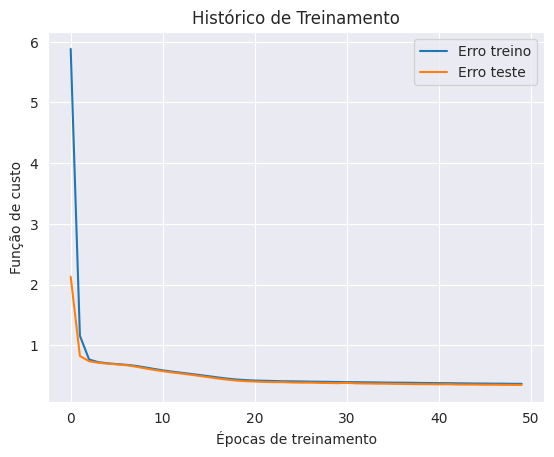

In [10]:
simple_nn = Sequential()
simple_nn.add(Dense(units=3, activation='relu', input_dim=x_treino.shape[1]))
simple_nn.add(Dense(units=1, activation='sigmoid'))

fit_neural_network(simple_nn)

Epoch 1/50


/home/danilo/Repos/DataMining/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6236 - loss: 1.1578 - val_accuracy: 0.6816 - val_loss: 0.5345
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6800 - loss: 0.6566 - val_accuracy: 0.6816 - val_loss: 0.5189
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6881 - loss: 0.5725 - val_accuracy: 0.6816 - val_loss: 0.4916
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6814 - loss: 0.5316 - val_accuracy: 0.6816 - val_loss: 0.4510
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6962 - loss: 0.4974 - val_accuracy: 0.8256 - val_loss: 0.4275
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7242 - loss: 0.4908 - val_accuracy: 0.8284 - val_loss: 0.4068
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7349 - loss: 0.4751 - val_accuracy: 0.8276 - val_loss: 0.3980
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7329 - loss: 0.4738 - val_accuracy: 0.8336 - val_

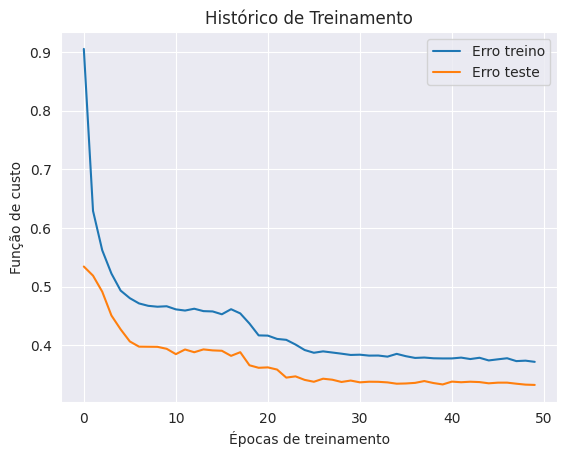

In [11]:
deep_nn = Sequential()
deep_nn.add(Dense(units=16, activation='relu', input_dim=x_treino.shape[1]))  # Primeira camada oculta
deep_nn.add(Dropout(0.2))  # Regularização para evitar overfitting
deep_nn.add(Dense(units=8, activation='relu'))  # Segunda camada oculta
deep_nn.add(Dropout(0.2))  # Regularização
deep_nn.add(Dense(units=1, activation='sigmoid'))  # Camada de saída

fit_neural_network(deep_nn)